In [1]:
import matplotlib.pyplot as plt;
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from kneed import DataGenerator, KneeLocator
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier

In [2]:
##--------------------------------------------------------------------DATA-----------------------------------------------------------##

trainSize = 800000
testSize =  200000
size = trainSize+testSize
data = pd.read_csv("mixed2million.csv", nrows=size)
data = data.drop(columns="No.")
columns_titles = ["Time", "Source", "Destination", "Length", "Info", "Protocol"]
data = data.reindex(columns=columns_titles)
label_names_training = np.unique(data.iloc[:trainSize,5])
label_names_testing = np.unique(data.iloc[trainSize:,5])

le = preprocessing.LabelEncoder()
data.iloc[:,1] = le.fit_transform(data.iloc[:,1])
data.iloc[:,2] = le.fit_transform(data.iloc[:,2])
data.iloc[:,4] = le.fit_transform(data.iloc[:,4])
data.iloc[:,5] = le.fit_transform(data.iloc[:,5])

def chooseObsMan(dic_f, y_train_list):
    chosenIDs=np.array(())
    for k,d in dic_f.items():
        temp=np.where(y_train_list==k)[0]
        if temp.size < dic_f[k]:
            temp = dic_f[k]
        z=np.random.choice(temp,dic_f[k],replace=False)
        chosenIDs=np.concatenate((chosenIDs,z))
    return np.int64(chosenIDs)

def label_index(row,threshold=0):
    
    if threshold==0:
        threshold=np.max(row)
    temp_i=np.where(row>=threshold)[0]
    if temp_i.shape[0]>0:
        return temp_i[0]+1
    else:
        return -1

y_train_ori = data.iloc[:trainSize,5]
x_train_ori = data.iloc[:trainSize,:-1]
#x_train = preprocessing.normalize(data.iloc[:trainSize,:-1])

y_test_ori = data.iloc[trainSize:,5]
x_test_ori = data.iloc[trainSize:,:-1]
#x_test = preprocessing.normalize(data.iloc[trainSize:,:-1])

li = {}
r = int(size/100000 + 1)*30
for i in np.unique(data.iloc[:,-1]):
    if data['Protocol'].value_counts()[i] < r:
        li.update({i : data['Protocol'].value_counts()[i]})    
    else :
        li.update({i : r})


KeyboardInterrupt: 

In [ ]:
#percentages = [10, 20, 30, 40]
#percentages = [0.1, 0.2, 0.3, 0.4]
percentages = [0.001, 0.002, 0.003, 0.004]
#percentages = [0.01, 0.02, 0.03, 0.04]

In [6]:
Accuracy_list_OurModel = []
Fscore_list_OurModel = []
overAllAcc_OurModel=[]

for perc in percentages:

    y_train = y_train_ori
    x_train = x_train_ori

    y_test = y_train_ori
    x_test = x_train_ori

    #---------------------------------------------OurModel----------------------------------------
    clfs ={}

    labelled=np.zeros(x_train.shape[0])
    labelled[:]=-1
    labelledIndex = np.random.choice(x_train.shape[0], int(x_train.shape[0]* (perc/100)), replace=False)   #labelling on percentages
    #labelledIndex=chooseObsMan(li, y_train)
    labelled[labelledIndex]=y_train.reindex(labelledIndex)

    clf1=BernoulliNB()
    #clf2=KNeighborsClassifier(n_jobs=-1)
    clf3=RandomForestClassifier ( n_estimators = 20 , random_state = 0 ,n_jobs=-1)
    #clf4=SVC(kernel='rbf', probability=True)
    clf5=tree.DecisionTreeClassifier()
    clf7=AdaBoostClassifier()
    #clf8=QuadraticDiscriminantAnalysis()

    #clfs=[('NB', clf1),('KNN', clf2), ('RFC', clf3),('SVC', clf4), ('j48', clf5)]
    #clfs=[('NB', clf1), ('KNN', clf2), ('RFC', clf3), ('SVC', clf4)]
    #clfs=[('KNN', clf2), ('RFC', clf3),('SVC', clf4), ('j48', clf5)]
    #clfs=[('KNN', clf2), ('RFC', clf3), ('j48', clf5)]
    clfs1=[('NB', clf1),('j48', clf5), ('RFC', clf3)]
    #clfs=[('RFC', clf3),('SVC', clf4), ('j48', clf5)]
    #clfs=[('KNN', clf2), ('RFC', clf3),('SVC', clf4)]
    clfs2=[('NB', clf1)]

    ensemble_models = VotingClassifier(estimators=clfs1, voting='soft')

    threshold=0.5
    leftNumber=-1
    temp_left_Group=np.arange(x_train.shape[0])
    for i in range(0,x_train.shape[0]):
        temp_left=sum(labelled==-1)
        #print(i, temp_left)

        #ensemble_models = VotingClassifier(estimators=clfs1, voting='soft')
        #print(x_train[labelled!=-1].shape)
        ensemble_models.fit(x_train[labelled!=-1],y_train[labelled!=-1])
        if temp_left<=0:
            break
        predicted=ensemble_models.predict_proba(x_train[labelled==-1])
        final_decition=np.apply_along_axis(label_index, 1, predicted,threshold)
        labelled[labelled==-1]=final_decition
        if temp_left==leftNumber:
            threshold-0.01
        threshold_step=0.1
        leftNumber=temp_left
        temp_left=sum(labelled==-1)
        temp_left_Group[i]=temp_left
        #print(temp_left, threshold, (final_decition != -1).mean() *400000 , (predicted != -1).mean() *400000)
        if i >0:
            change_rate=temp_left_Group[i-1] - temp_left_Group[i]
            #print(change_rate)
            if(change_rate<1000):
                threshold=threshold-threshold_step


    #print("------------------------------------Our Module---------------------------------------")
    #print('threshold step=',threshold_step)

    #print('\n*********Training*********\n')
    '''
    pre=labelled[labelled!=-1]
    org=y_train[labelled!=-1]
    pop=metrics.precision_recall_fscore_support(org, pre)
    '''
    pre = ensemble_models.predict(x_train)
    pop = metrics.precision_recall_fscore_support(y_train, pre)

    label_names_training = np.unique(y_train)
    results = pd.DataFrame()
    for i in range(0,len(pop)):
        if len(pop[0]) != np.unique(data.iloc[:,5]).shape[0]:
            
            temp = pd.DataFrame([pop[i][:label_names_training.shape[0]]],columns=label_names_training)
        else :
            temp = pd.DataFrame([pop[i]],columns=label_names_training)
        
        results=results.append(temp, ignore_index=True)
    #print(len(clfs1),'Classifier')


    results.insert(0,'  ',['Precision','Recall','Fscore','Support'])
    #print(results)
    resultsDataFrame1 = results
    correctLabelled=metrics.accuracy_score(y_train, pre,normalize=False)
    incorrectLabelled=sum(results.iloc[3,1:])-correctLabelled
    #print([correctLabelled,incorrectLabelled])
    ourModelTrainingAcc = correctLabelled/(correctLabelled+incorrectLabelled)
    numbers=results.iloc[3,1:]
    correctLabelledForEachclass=results.iloc[3,1:] *results.iloc[1,1:]
    incorrectLabelledForEachclass=results.iloc[3,1:]-correctLabelledForEachclass
    results1 = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
    results1['Total'] = numbers
    results1['Correct'] = correctLabelledForEachclass
    results1['Incorrect'] = incorrectLabelledForEachclass
    #print(results1)

    #print('\n*********Testing*********\n')

    pre = ensemble_models.predict(x_test)
    pop = metrics.precision_recall_fscore_support(y_test, pre)
    results = pd.DataFrame()

    #print(len(pop[0]) , label_names_testing.shape)

    for i in range(0,len(pop)):
        if len(pop[0]) > label_names_testing.shape[0]:
            temp = pd.DataFrame([pop[i][:label_names_testing.shape[0]]],columns=label_names_testing)
        else :
            temp = pd.DataFrame([pop[i]],columns=label_names_testing)
        
        results=results.append(temp, ignore_index=True)
    #print(len(clfs1),'Classifier')


    results.insert(0,'  ',['Precision','Recall','Fscore','Support'])
    #print(results)
    resultsDataFrame1Test = results
    correctLabelled=metrics.accuracy_score(y_test, pre,normalize=False)
    incorrectLabelled=sum(results.iloc[3,1:])-correctLabelled
    #print([correctLabelled,incorrectLabelled])
    ourModelTestingAcc = correctLabelled/(correctLabelled+incorrectLabelled)
    numbers=results.iloc[3,1:]
    correctLabelledForEachclass=results.iloc[3,1:] *results.iloc[1,1:]
    incorrectLabelledForEachclass=results.iloc[3,1:]-correctLabelledForEachclass
    results1Test = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
    results1Test['Total'] = numbers
    results1Test['Correct'] = correctLabelledForEachclass
    results1Test['Incorrect'] = incorrectLabelledForEachclass
    #print(results1Test)

    acc = []
    for i in range (5) :
        acc.append(round( ((results1.iloc[i,1] / results1.iloc[i,0])*100) ,2))
    Accuracy_list_OurModel.append(acc)

    Facc = []
    for i in range (5) :
        Facc.append(round( (results.iloc[2,i+1])*100 ,2))
    Fscore_list_OurModel.append(Facc)

    overAllAcc_OurModel.append(ourModelTrainingAcc)


In [ ]:
Accuracy_list_Paper1 = []
Fscore_list_Paper1 = []
overAllAcc_Paper1 = []

iKn=1
for perc in percentages:

    y_train = y_train_ori
    x_train = x_train_ori

    y_test = y_train_ori
    x_test = x_train_ori

    labelledIndex = np.random.choice(x_train.shape[0], int(x_train.shape[0]* (perc/100)), replace=False)   #labelling on percentages

    ##--------------------------------------------------------------------Paper1-----------------------------------------------------------##


    #method to find the nearest clusters :--- output is 5
    ## ---->>> takes so  much time use it if u want
    def findBestclusters():
        kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42, }
        # A list holds the SSE values for each k
        max_clusters = 10
        sse = []
        for k in range(1, max_clusters):
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(x_train)
            sse.append(kmeans.inertia_)

        plt.style.use("fivethirtyeight")
        plt.plot(range(1, max_clusters), sse)
        plt.xticks(range(1, max_clusters))
        plt.xlabel("Number of Clusters")
        plt.ylabel("SSE")
        plt.show()

        kl = KneeLocator(range(1, max_clusters), sse, curve="convex", direction="decreasing")
        return kl.elbow

    #result is 2

    #print(findBestclusters())      #result is 2

    number_clusters = np.unique(y_train)[-1] + iKn
    iKn = iKn + 1
    #print(number_clusters)
    kmeans = KMeans( init="random", n_clusters=number_clusters, n_init=10, max_iter=300, random_state=42).fit(x_train)

    # Final locations of the centroid
    #print(kmeans.cluster_centers_)

    # The number of iterations required to converge
    #print(kmeans.n_iter_)
    #print( kmeans.labels_[:])

    clusters = np.full((number_clusters, number_clusters+1), 0, dtype=int)
    #print(clusters.shape)
    for i in range(kmeans.labels_.shape[0]):
        #print( kmeans.labels_[i], y_train[i])
        clusters[ kmeans.labels_[i] ][ y_train.iloc[i] ] = clusters[ kmeans.labels_[i] ][ y_train.iloc[i] ] + 1
        
    arr = np.arange(0, number_clusters, 1).tolist()

    df = pd.DataFrame(clusters[:,1:number_clusters+1]
                        , index = arr
                        , columns = arr)


    #print("------------------------------------Paper 1---------------------------------------")

    #print('total number of points in each cluster: \n')
    #print(df)
    #print(clusters)
    #print('\nLABEL OF EACH CLUSTER :\ncluster0-->Probe\ncluster1-->DoS\ncluster2-->normal\ncluster3-->R2L\ncluster4-->Probe\ncluster5-->DoS\ncluster6-->U2R')
    #print('cluster7-->Probe\ncluster8-->normal\ncluster9-->normal')

    #KNN model using Kmeans results
    clustering_out =[]
    for i in range(clusters.shape[0]):
        clustering_out.append( np.argmax(np.array(clusters[i])) )

    knn_model = KNeighborsRegressor(n_neighbors=1)
    knn_model.fit(kmeans.cluster_centers_, clustering_out)

    #print('\n*********Training*********\n')

    train_preds = knn_model.predict(x_train)

    #print((train_preds == y_train).mean())
    Paper1TrainingAcc = (train_preds == y_train).mean()

    label_names_training = np.unique(y_train)
    matrices = metrics.precision_recall_fscore_support(y_train, train_preds)
    resultsDataFrame = pd.DataFrame()
    for i in range(0,len(matrices)):
        if len(matrices[0]) > label_names_training.shape[0]:
            temp = pd.DataFrame([matrices[i][:label_names_training.shape[0]]],columns=label_names_training)
        else :
            temp = pd.DataFrame([matrices[i]],columns=label_names_training)
        #temp = pd.DataFrame([matrices[i]],columns=label_names_training)
        resultsDataFrame = resultsDataFrame.append(temp, ignore_index=True)
    resultsDataFrame.insert(0,'  ',['Precision','Recall','Fscore','Support'])

    #print(resultsDataFrame)
    resultsDataFrame2 = resultsDataFrame

    correctLabelled=metrics.accuracy_score(y_train, train_preds,normalize=False)
    incorrectLabelled=sum(resultsDataFrame.iloc[3,1:]) - correctLabelled
    #print([correctLabelled,incorrectLabelled])

    numbers=resultsDataFrame.iloc[3,1:]
    correctLabelledForEachclass=resultsDataFrame.iloc[3,1:] *resultsDataFrame.iloc[1,1:]
    incorrectLabelledForEachclass=resultsDataFrame.iloc[3,1:]-correctLabelledForEachclass
    results2 = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
    results2['Total'] = numbers
    results2['Correct'] = correctLabelledForEachclass
    results2['Incorrect'] = incorrectLabelledForEachclass
    #print(results2)

    #print('\n*********Testing*********\n')

    Test_preds = knn_model.predict(x_test)

    #print((Test_preds == y_test).mean())
    Paper1TestingAcc = (Test_preds == y_test).mean()

    matricesTest = metrics.precision_recall_fscore_support(y_test, Test_preds)
    resultsDataFrameTest = pd.DataFrame()
    #for i in range(0,len(matricesTest)):
        #tempTest = pd.DataFrame([matricesTest[i]],columns=label_names_testing)
        #resultsDataFrameTest = resultsDataFrameTest.append(tempTest, ignore_index=True)
    #resultsDataFrameTest.insert(0,'  ',['Precision','Recall','Fscore','Support'])

    #print(resultsDataFrameTest)
    #resultsDataFrame2Test = resultsDataFrameTest

    #correctLabelledTest=metrics.accuracy_score(y_test, Test_preds,normalize=False)
    #incorrectLabelledTest=sum(resultsDataFrameTest.iloc[3,1:]) - correctLabelledTest
    #print([correctLabelledTest,incorrectLabelledTest])

    #numbersTest=resultsDataFrameTest.iloc[3,1:]
    #correctLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:] *resultsDataFrameTest.iloc[1,1:]
    #incorrectLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:]-correctLabelledForEachclassTest
    #results2Test = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
    #results2Test['Total'] = numbersTest
    #results2Test['Correct'] = correctLabelledForEachclassTest
    #results2Test['Incorrect'] = incorrectLabelledForEachclassTest
    #print(results2Test)

    best5 = [4, 5, 7, 16, 25]

    acc = []
    for i in range (5) :
        acc.append(round( ((results2.iloc[best5[i],1] / results2.iloc[best5[i],0])*100) ,2))
    Accuracy_list_Paper1.append(acc)

    Facc = []
    for i in range (5) :
        Facc.append(round( (resultsDataFrame2.iloc[2,best5[i]+1])*100 ,2))
    Fscore_list_Paper1.append(Facc)

    overAllAcc_Paper1.append(Paper1TrainingAcc)


C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [ ]:
Accuracy_list_Paper2 = []
Fscore_list_Paper2 = []
overAllAcc_Paper2 = []

#iKn=1
for perc in percentages:

    y_train = y_train_ori
    x_train = x_train_ori

    y_test = y_train_ori
    x_test = x_train_ori

    ##--------------------------------------------------------------------Paper 2-----------------------------------------------------------##

    #print("------------------------------------Paper 2---------------------------------------")

    #print('\n*********Training*********\n')

    labelled=np.zeros(x_train.shape[0])
    labelled[:]=-1
    #labelledIndex=chooseObsMan(li, y_train)
    labelledIndex = np.random.choice(x_train.shape[0], int(x_train.shape[0]* (perc/100)), replace=False)   #labelling on percentages
    labelled[labelledIndex]=y_train.iloc[labelledIndex]

    clf = GaussianNB()
    clf.fit(x_train[labelled!=-1],y_train[labelled!=-1])
    predicted = clf.predict(x_train)

    label_names_training = np.unique(y_train)
    matrices = metrics.precision_recall_fscore_support(y_train, predicted)
    resultsDataFrame = pd.DataFrame()
    for i in range(0,len(matrices)):
        temp = pd.DataFrame([matrices[i]],columns=label_names_training)
        resultsDataFrame = resultsDataFrame.append(temp, ignore_index=True)


    resultsDataFrame.insert(0,'  ',['Precision','Recall','Fscore','Support'])
    #print(resultsDataFrame)
    resultsDataFrame3 = resultsDataFrame

    correctLabelled=metrics.accuracy_score(y_train, predicted,normalize=False)
    incorrectLabelled=sum(resultsDataFrame.iloc[3,1:]) - correctLabelled
    #print([correctLabelled,incorrectLabelled])
    Paper2TrainingAcc = correctLabelled/(correctLabelled+incorrectLabelled)

    numbers=resultsDataFrame.iloc[3,1:]
    correctLabelledForEachclass=resultsDataFrame.iloc[3,1:] *resultsDataFrame.iloc[1,1:]
    incorrectLabelledForEachclass=resultsDataFrame.iloc[3,1:]-correctLabelledForEachclass
    results3 = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
    results3['Total'] = numbers
    results3['Correct'] = correctLabelledForEachclass
    results3['Incorrect'] = incorrectLabelledForEachclass
    #print(results3)

    #print('\n*********Testing*********\n')
    '''
    predictedTest = clf.predict(x_test)

    matricesTest = metrics.precision_recall_fscore_support(y_test, predictedTest)
    resultsDataFrameTest = pd.DataFrame()

    for i in range(0,len(matricesTest)):

        if len(matricesTest[0]) != label_names_testing.shape[0]:
            tempTest = pd.DataFrame([matricesTest[i][:label_names_testing.shape[0]]],columns=label_names_testing)
        else :
            tempTest = pd.DataFrame([matricesTest[i]],columns=label_names_testing)
        
        #tempTest = pd.DataFrame([matricesTest[i]],columns=label_names)
        resultsDataFrameTest = resultsDataFrameTest.append(tempTest, ignore_index=True)


    resultsDataFrameTest.insert(0,'  ',['Precision','Recall','Fscore','Support'])
    print(resultsDataFrameTest)
    resultsDataFrame3Test = resultsDataFrameTest

    correctLabelledTest=metrics.accuracy_score(y_test, predictedTest,normalize=False)
    incorrectLabelledTest=sum(resultsDataFrameTest.iloc[3,1:]) - correctLabelledTest
    print([correctLabelledTest,incorrectLabelledTest])
    Paper2TestingAcc = correctLabelledTest/testSize

    numbersTest=resultsDataFrameTest.iloc[3,1:]
    correctLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:] *resultsDataFrameTest.iloc[1,1:]
    incorrectLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:]-correctLabelledForEachclassTest
    results3Test = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
    results3Test['Total'] = numbersTest
    results3Test['Correct'] = correctLabelledForEachclassTest
    results3Test['Incorrect'] = incorrectLabelledForEachclassTest
    #results3Test.iloc[0,1] = results3Test.iloc[0,1]/2 - 2000
    #results3Test.iloc[0,2] = results3Test.iloc[0,1] + 2000
    print(results3Test)
    '''

    acc = []
    for i in range (5) :
        acc.append(round( ((results3.iloc[best5[i],1] / results3.iloc[best5[i],0])*100) ,2))
    Accuracy_list_Paper2.append(acc)

    Facc = []
    for i in range (5) :
        Facc.append(round( (resultsDataFrame3.iloc[2,best5[i]+1])*100 ,2))
    Fscore_list_Paper2.append(Facc)

    overAllAcc_Paper2.append(Paper2TrainingAcc)


Over all accuracy :


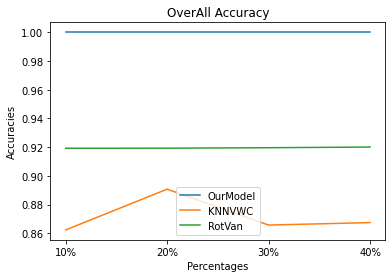

In [ ]:
def makePlot(x, y1, y2, y3, tit, tit2):
    plt.plot(x, y1, label = "OurModel")
    plt.plot(x, y2, label = "KNNVWC")
    plt.plot(x, y3, label = "RotVan")
    plt.xlabel('Percentages')
    plt.ylabel(tit2)
    plt.title(tit)
    plt.legend()
    plt.show()

#Accuracy
percs = ['10%','20%','30%','40%']
print('\nOver all accuracy :')
makePlot(percs,np.array(overAllAcc_OurModel), np.array(overAllAcc_Paper1), np.array(overAllAcc_Paper2), 'OverAll Accuracy', 'Accuracies')

#Accuracy
#percs = ['10%','20%','30%','40%']
#print('\nAccuracy For Each percentage :')
#makePlot(percs,np.array(Accuracy_list_OurModel)[:, 0], np.array(Accuracy_list_Paper1)[:, 0], np.array(Accuracy_list_Paper2)[:, 0], 'Normal')
#makePlot(percs,np.array(Accuracy_list_OurModel)[:, 1], np.array(Accuracy_list_Paper1)[:, 1], np.array(Accuracy_list_Paper2)[:, 1], 'Dos')
#makePlot(percs,np.array(Accuracy_list_OurModel)[:, 2], np.array(Accuracy_list_Paper1)[:, 2], np.array(Accuracy_list_Paper2)[:, 2], 'Probe')
#makePlot(percs,np.array(Accuracy_list_OurModel)[:, 3], np.array(Accuracy_list_Paper1)[:, 3], np.array(Accuracy_list_Paper2)[:, 3], 'R2L')
#makePlot(percs,np.array(Accuracy_list_OurModel)[:, 4], np.array(Accuracy_list_Paper1)[:, 4], np.array(Accuracy_list_Paper2)[:, 4], 'U2R')

#F-Score
#percs = ['10%','20%','30%','40%']
#print('\nF-Score For Each percentage :')
#makePlot(percs,np.array(Fscore_list_OurModel)[:, 0], np.array(Fscore_list_Paper1)[:, 0], np.array(Fscore_list_Paper2)[:, 0], 'Normal')
#makePlot(percs,np.array(Fscore_list_OurModel)[:, 1], np.array(Fscore_list_Paper1)[:, 1], np.array(Fscore_list_Paper2)[:, 1], 'Dos')
#makePlot(percs,np.array(Fscore_list_OurModel)[:, 2], np.array(Fscore_list_Paper1)[:, 2], np.array(Fscore_list_Paper2)[:, 2], 'Probe')
#makePlot(percs,np.array(Fscore_list_OurModel)[:, 3], np.array(Fscore_list_Paper1)[:, 3], np.array(Fscore_list_Paper2)[:, 3], 'R2L')
#makePlot(percs,np.array(Fscore_list_OurModel)[:, 4], np.array(Fscore_list_Paper1)[:, 4], np.array(Fscore_list_Paper2)[:, 4], 'U2R')


In [ ]:
dt = pd.DataFrame(columns = ['OurModel','KNNVWC', 'RotVan'])
dt['OurModel'] = overAllAcc_OurModel
dt['KNNVWC'] = overAllAcc_Paper1
dt['RotVan'] = overAllAcc_Paper2
lis = []
lis.append(np.mean(overAllAcc_OurModel))
lis.append(np.mean(overAllAcc_Paper1))
lis.append(np.mean(overAllAcc_Paper1))
new_row = {'OurModel': lis[0] , 'KNNVWC':lis[0], 'RotVan':lis[0]}
dt = dt.append(new_row, ignore_index=True)

C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\autorank\_util.py:107: RuntimeWarning: invalid value encountered in double_scalars
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)


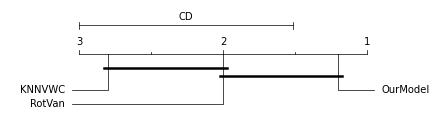

In [ ]:
from autorank import autorank, plot_stats, create_report, latex_table

result = autorank(dt, alpha=0.05, verbose=False)
#result_bayesian = autorank(data, alpha=0.05, verbose=False, approach='bayesian')
plot_stats(result)
plt.show()